# Do interface design to further filter out unproductive designs prior to looping

In [1]:
# %load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers
running on node: sofia


In [2]:
os.chdir("/home/broerman/projects/crispy_shifty")
sys.path.insert(0, os.getcwd())

In [3]:
def create_tasks(selected, options):
    with open(selected, "r") as f:
        for line in f:
            tasks = {"options": "-corrections::beta_nov16 true"}
            tasks["extra_options"] = options
            tasks["pdb_path"] = line.rstrip()
            yield tasks

In [ ]:

# Python standard library
import os
import pwd
import socket
import sys

# 3rd party library imports
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

# Rosetta library imports
from pyrosetta.distributed.cluster.core import PyRosettaCluster

# Custom library imports
sys.path.insert(0, os.getcwd())
from crispy_shifty.protocols.design import one_state_design_unlooped_dimer  # the functions we will distribute

print(f"View dashboard at http://{socket.gethostname()}:8787")

selected = os.path.join(os.getcwd(), "projects/crispy_shifty_dimers/01_make_states/states.list")

options = {
    "-out:level": "100",
    "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
    "-indexed_structure_store:fragment_store": "/net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5",
    "-precompute_ig": "true"
}

output_path = os.path.join(os.getcwd(), "projects/crispy_shifty_dimers/02_design_filter")
os.makedirs(output_path, exist_ok=True)

if __name__ == "__main__":
    # configure SLURM cluster as a context manager
    with SLURMCluster(
        cores=1,
        processes=1,
        job_cpu=1,
        memory="10GB",
        queue="backfill",
        walltime="11:30:00",
        death_timeout=120,
        local_directory="$TMPDIR",  # spill worker litter on local node temp storage
        log_directory=os.path.join(output_path, "slurm_logs"),
        extra=["--lifetime", "11h", "--lifetime-stagger", "5m"],
    ) as cluster:
        print(cluster.job_script())
        # scale between 1-300 workers,
        cluster.adapt(
            minimum=1,
            maximum=300,
            wait_count=999,  # Number of consecutive times that a worker should be suggested for removal it is removed
            interval="5s",  # Time between checks
            target_duration="60s",
        )
        # setup a client to interact with the cluster as a context manager
        with Client(cluster) as client:
            print(client)
            client.upload_file(
                os.path.join(os.getcwd(), "crispy_shifty/protocols/design.py")
            )  # upload the script that contains the functions to distribute
            PyRosettaCluster(
                client=client,
                logging_level="ERROR",
                output_path=output_path,
                project_name="crispy_shifty_dimers",
                scratch_dir=output_path,
                simulation_name="02_design_filter",
                tasks=create_tasks(selected, options),
                nstruct=10,
            ).distribute(protocols=[one_state_design_unlooped_dimer])
            client.close()
        cluster.scale(0)
        cluster.close()
    print("distributed run complete")

View dashboard at http://dig62:8787
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/slurm_logs/dask-worker-%J.err
#SBATCH -o /mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/slurm_logs/dask-worker-%J.out
#SBATCH -p medium
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=12G
#SBATCH -t 23:30:00

/projects/crispy_shifty/envs/crispy/bin/python -m distributed.cli.dask_worker tcp://172.16.131.92:34317 --nthreads 1 --memory-limit 11.18GiB --name dummy-name --nanny --death-timeout 120 --local-directory $TMPDIR --lifetime 23h --lifetime-stagger 5m --protocol tcp://

<Client: 'tcp://172.16.131.92:34317' processes=0 threads=0, memory=0 B>


KeyboardInterrupt: 

In [3]:
def read_scorefile(scores):
    import pandas as pd

    scores = pd.read_json(scores, orient="records", typ="frame", lines=True)
    scores = scores.T
    mat = scores.values
    n = mat.shape[0]
    dicts = list(mat[range(n), range(n)])
    index = scores.index
    tabulated_scores = pd.DataFrame(dicts, index=index)
    return tabulated_scores

os.chdir("/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers")
output_path = os.path.join(os.getcwd(), "02_design_filter")
scores = os.path.join(output_path, "scores.json")
scores_df = read_scorefile(scores)
scores_df.head()

,bb_clash,bb_clash_A,bb_clash_B,cms_ac_bn,cms_dhr,cms_dhr_ac,cms_dhr_bn,dhr_ac_int_count,dhr_bn_int_count,dhr_int_count,...,shift_A,shift_B,ss_sc,total_score,wnm_1,wnm_2,wnm_3,wnm_4,wnm_hlx,yhh_planarity
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_c6b1cf65d1314fa4a7efe90793d83846.pdb.bz2,110.83558654785156,56.11193084716797,54.72365951538086,-1.000000,368.517517,514.184814,637.900879,26.0,35.0,19.0,...,-6.0,6.0,0.713926,41261.58817176744,0.354899,0.397061,0.329438,0.365875,0.129802,0.0
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_1c00614344c540838651ab1189b900e9.pdb.bz2,4650.0625,41.235984802246094,41.235984802246094,-1.000000,245.856781,320.443359,0.000000,12.0,37.0,15.0,...,1.0,-1.0,0.733583,22383.564461821425,0.363062,0.459005,0.373733,0.435767,0.089698,0.0
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_d1ad7b79dddf4566bed7b5cfc3893bcd.pdb.bz2,4802.529296875,37.104209899902344,613.51220703125,-1.000000,152.555206,324.429718,314.094727,15.0,31.0,14.0,...,5.0,3.0,0.720846,30201.420730267128,0.281702,0.284034,0.373289,0.349887,0.115567,0.0015607019201311911
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_6fbd5efe0f2d418eaaede06ebfcafd49.pdb.bz2,103.79744720458984,69.95219421386719,33.758880615234375,0.121686,322.327301,384.285004,297.629730,20.0,10.0,5.0,...,5.0,-1.0,0.725128,20943.983241058155,0.256686,0.225569,0.257751,0.200958,0.108887,0.0
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_26cfe49f56cd433b853590bf0036a35b.pdb.bz2,2832.929931640625,37.104209899902344,2794.31787109375,-1.000000,128.971451,296.732544,126.221008,15.0,24.0,14.0,...,5.0,2.0,0.703402,22138.093955425633,0.286762,0.299825,0.254358,0.303265,0.104817,0.0015607019201311911


In [4]:
print(scores_df.columns)
print(len(scores_df))

Index(['bb_clash', 'bb_clash_A', 'bb_clash_B', 'cms_ac_bn', 'cms_dhr',
       'cms_dhr_ac', 'cms_dhr_bn', 'dhr_ac_int_count', 'dhr_bn_int_count',
       'dhr_int_count', 'dslf_fa13', 'fa_atr', 'fa_dun', 'fa_elec',
       'fa_intra_rep', 'fa_intra_sol_xover4', 'fa_rep', 'fa_sol',
       'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sc', 'hbond_sr_bb', 'lk_ball_wtd',
       'loop_dist_A', 'loop_dist_B', 'omega', 'p_aa_pp', 'parent',
       'parent_length', 'parent_loop_dist', 'parent_path', 'pivot_helix_A',
       'pivot_helix_B', 'pre_break_helix', 'pro_close', 'rama_prepro', 'ref',
       'sc_ac_bn', 'sc_dhr', 'sc_dhr_ac', 'sc_dhr_bn', 'score', 'score_1',
       'score_124', 'score_134', 'score_14', 'score_2', 'score_23', 'score_3',
       'score_4', 'score_per_res', 'shift_A', 'shift_B', 'ss_sc',
       'total_score', 'wnm_1', 'wnm_2', 'wnm_3', 'wnm_4', 'wnm_hlx',
       'yhh_planarity'],
      dtype='object')
12993


In [5]:
# Add the input path to the dataframe
import pyrosetta.distributed.cluster as cluster
for index, row in tqdm(scores_df.iterrows()):
    input_path = cluster.get_scores_dict(index)['instance']['tasks']['pdb_path']
    scores_df.at[index, 'input_path'] = input_path

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
12993it [02:43, 79.68it/s]


100%|██████████| 12993/12993 [00:00<00:00, 1810578.15it/s]


<AxesSubplot:ylabel='Count'>

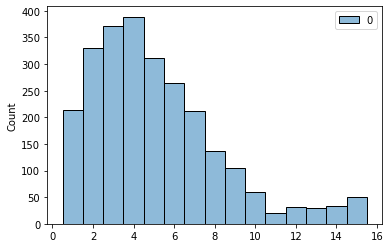

In [6]:
input_path_dict = {}
for input_path in tqdm(scores_df['input_path']):
    if input_path in input_path_dict:
        input_path_dict[input_path] += 1
    else:
        input_path_dict[input_path] = 1

sns.histplot(input_path_dict.values(), discrete=True)

In [4]:
# Filter, then check whether there is significant variation among scores for designs from the same input

scores_df['de_1_4'] = scores_df['score_14'] - scores_df['score_1'] - scores_df['score_4']
scores_df['de_14_2'] = scores_df['score_124'] - scores_df['score_14'] - scores_df['score_2']
scores_df['de_14_3'] = scores_df['score_134'] - scores_df['score_14'] - scores_df['score_3']
scores_df['de_2_3'] = scores_df['score_23'] - scores_df['score_2'] - scores_df['score_3']
scores_df['wnm'] = scores_df[['wnm_1', 'wnm_2', 'wnm_3', 'wnm_4']].max(axis=1)
scores_df['delta_loop_dist_A'] = scores_df['loop_dist_A'].astype(float) - scores_df['parent_loop_dist'].astype(float)
scores_df['delta_loop_dist_B'] = scores_df['loop_dist_B'].astype(float) - scores_df['parent_loop_dist'].astype(float)

def histplot_df(df):
    sns.set(
        context="talk",
        font_scale=1,  # make the font larger; default is pretty small
        style="ticks",  # make the background white with black lines
        palette="colorblind",  # a color palette that is colorblind friendly!
    )

    fig, axs = plt.subplots(4, 6, figsize=(24,16))

    cols = [
        "cms_dhr",
        "cms_dhr_ac",
        "cms_dhr_bn",
        "cms_ac_bn",
        "de_1_4",
        "de_14_2",
        "de_14_3",
        "de_2_3",
        "score_per_res",
        "delta_loop_dist_A",
        "delta_loop_dist_B",
        "wnm",
        "wnm_1",
        "wnm_2",
        "wnm_3",
        "wnm_4",
        "wnm_hlx",
        "ss_sc",
        "sc_dhr",
        "sc_dhr_ac",
        "sc_dhr_bn",
        "sc_ac_bn"
    #     "parent",
    ]

    for col, ax in tqdm(zip(cols, axs.flatten())):
        sns.histplot(
            data=df,
            x=col,
            ax=ax,
    #         kde=True
    #         hue='parent'
            bins=100
        )

    plt.tight_layout()

22it [00:01, 13.42it/s]


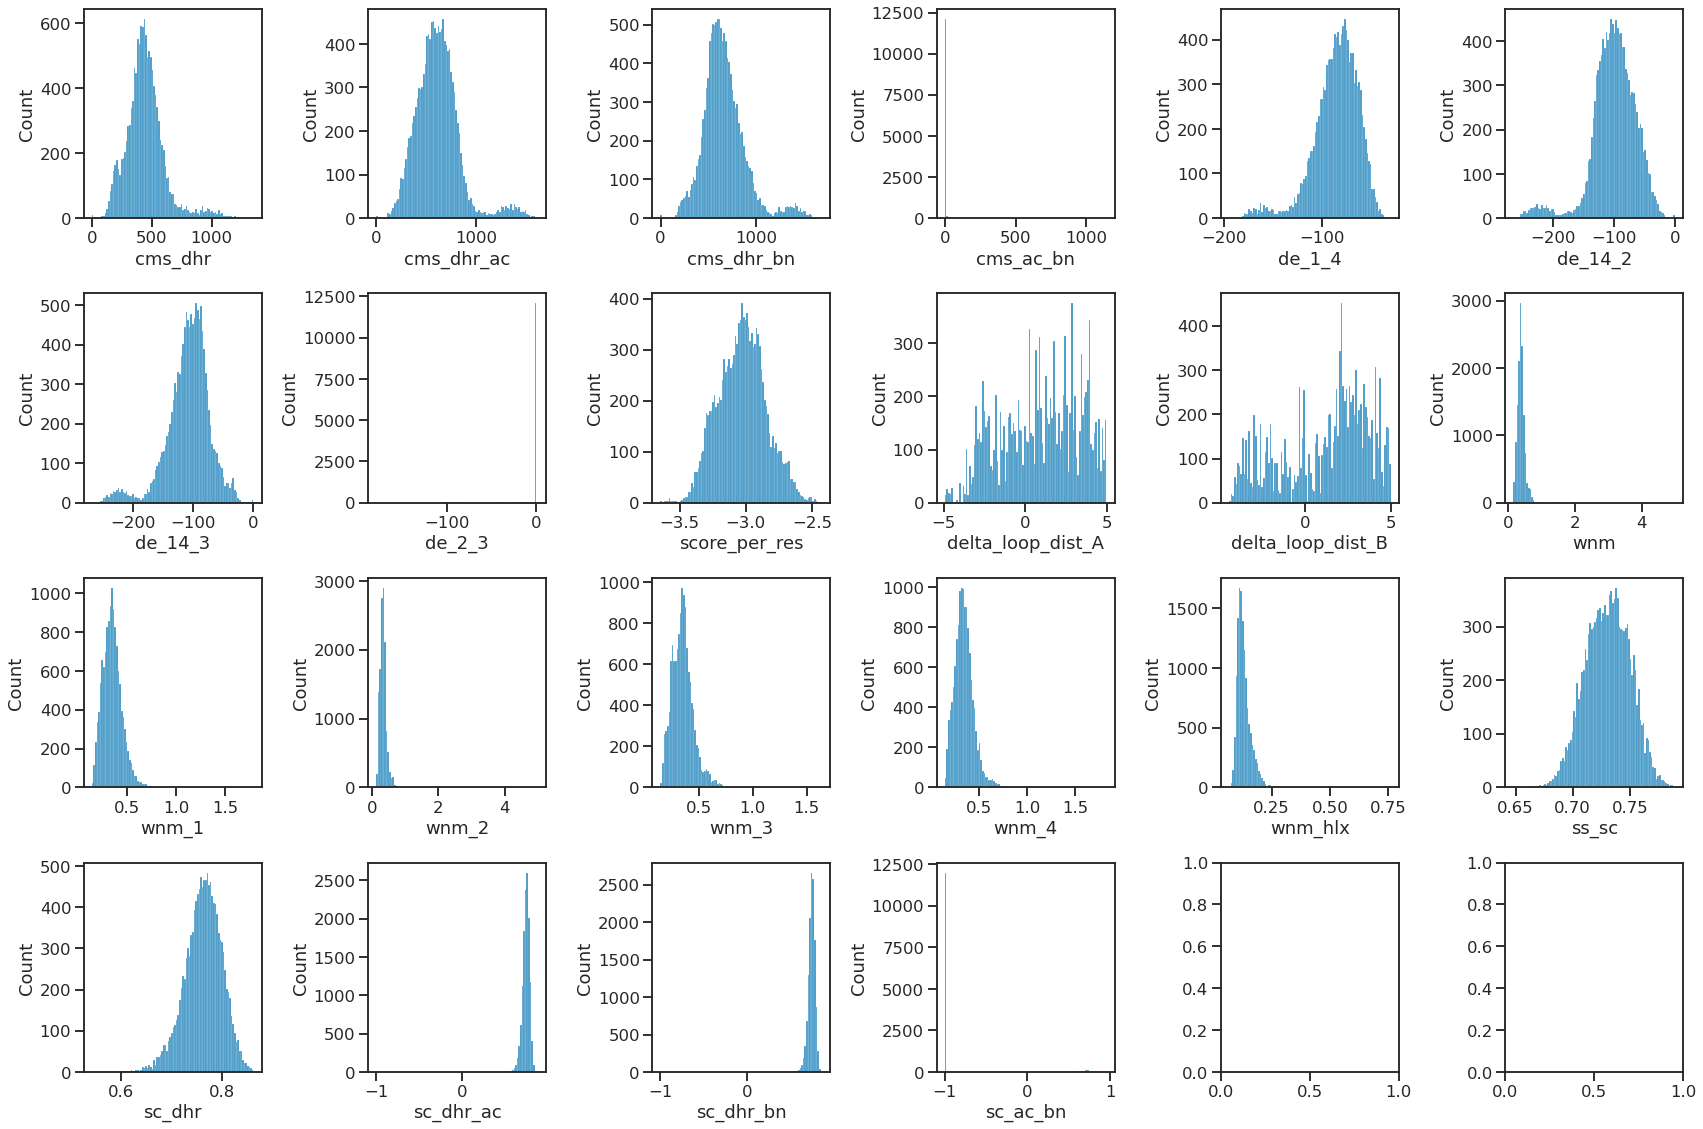

In [5]:
histplot_df(scores_df)

In [6]:
def filter_df(df, cutoffs):
    filtered_df = df

    for score_term, cutoff, greaterthan in cutoffs:
        if greaterthan:
            filtered_df = filtered_df[filtered_df[score_term] > cutoff]
        else:
            filtered_df = filtered_df[filtered_df[score_term] < cutoff]

    print(len(filtered_df))
    
    return filtered_df

def filter_df_delta(df, parent_df, delta_cutoffs):
    filtered_df = df

    for score_term, parent_term, cutoff, greaterthan in delta_cutoffs:
        filtered_series = filtered_df[score_term]
        parent_scores = parent_df.loc[filtered_df['parent'], parent_term]
        parent_scores.index = filtered_series.index
        # print(filtered_series)
        # print(parent_scores)
        # print(parent_scores - filtered_series < cutoff)
        if greaterthan:
            filtered_df = filtered_df[filtered_series - parent_scores > -cutoff]
        else:
            filtered_df = filtered_df[filtered_series - parent_scores < cutoff]
    
    print(len(filtered_df))
    
    return filtered_df

In [7]:
# Filter designs- remove worst by worst9mer and whether the designs are exploded

cutoffs = [('cms_dhr', 1, 1),
           ('cms_dhr_ac', 1, 1),
           ('cms_dhr_bn', 1, 1),
           ('wnm', 0.4, 0),
           ('wnm_hlx', 0.15, 0)
]

filtered_df = filter_df(scores_df, cutoffs)

6120


22it [00:01, 11.23it/s]


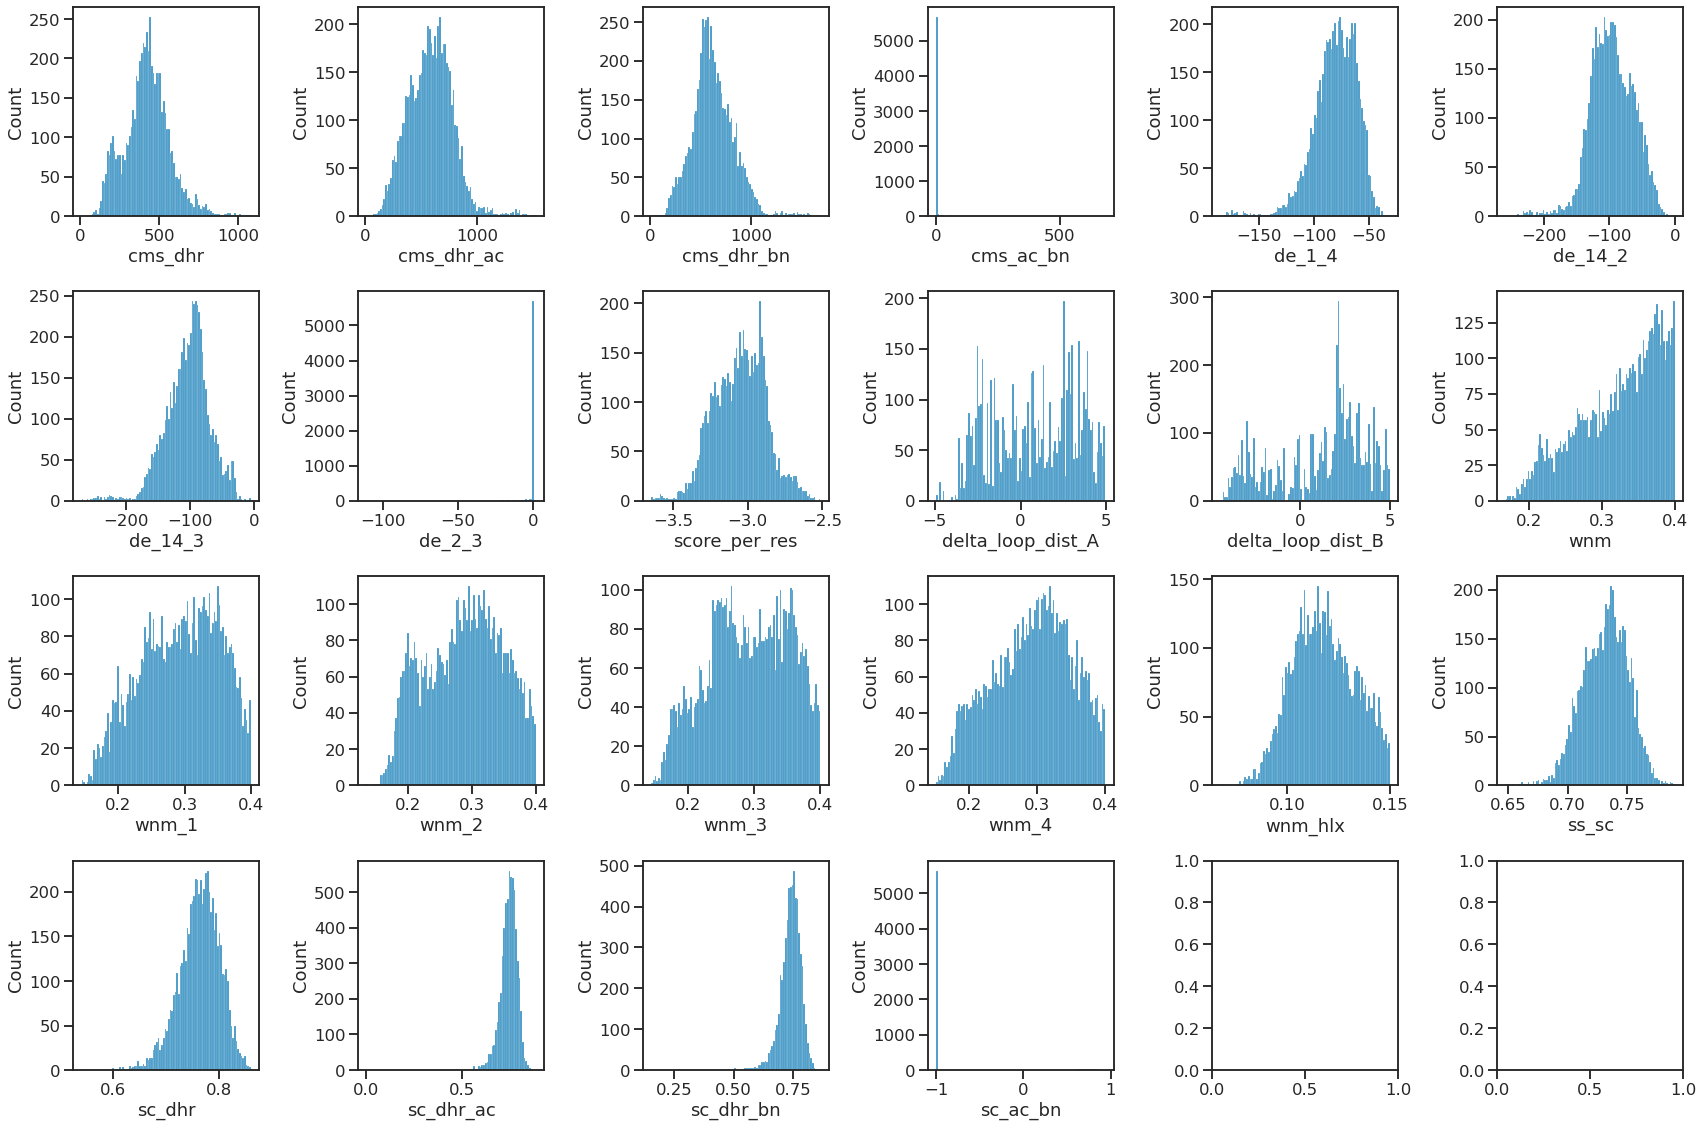

In [8]:
histplot_df(filtered_df)

In [9]:
parent_path = os.path.join(os.getcwd(), "00_inputs")
parent_scores = os.path.join(parent_path, "scaffold_scores.json")
parent_df = read_scorefile(parent_scores)
parent_df.set_index('name', inplace=True) # replaces the indexing by path to indexing by name
parent_df.head()

,cms_dhr,dslf_fa13,fa_atr,fa_dun_dev,fa_dun_rot,fa_dun_semi,fa_elec,fa_intra_atr_xover4,fa_intra_elec,fa_intra_rep_xover4,...,score,score_1,score_12,score_2,score_per_res,ss_sc,total_score,wnm_1,wnm_2,wnm_hlx
name,,,,,,,,,,,,,,,,,,,,,
DHR79,465.784760,0.0,-1400.636238,20.246144,145.179909,274.889648,-579.788253,-75.762132,-46.974228,73.894970,...,-561.677002,-245.034546,-561.677002,-251.905350,-2.553077,0.698439,-561.676986,0.322625,0.316925,0.094490
DHR39,321.138519,0.0,-1021.834993,17.066784,143.013018,193.845212,-399.394071,-59.330212,-31.171610,63.490618,...,-385.315033,-170.901306,-385.315033,-169.123169,-2.335243,0.731973,-385.315035,0.377876,0.327590,0.085988
DHR82,521.558899,0.0,-1498.559091,21.318266,188.024945,262.872950,-583.674273,-79.204600,-40.859747,99.079365,...,-621.641541,-269.689850,-621.641541,-283.966553,-2.726498,0.744233,-621.641546,0.226993,0.237057,0.110452
DHR53,357.954865,0.0,-1060.006597,10.302994,129.002023,184.958473,-407.824125,-53.968461,-22.101187,61.719093,...,-457.311920,-204.453018,-457.311920,-195.076950,-2.722095,0.788842,-457.311918,0.384927,0.392240,0.087457
DHR54,401.634857,0.0,-1047.650966,13.488556,126.581043,188.660628,-426.607112,-60.735843,-40.887647,66.710380,...,-449.422302,-189.710556,-449.422302,-196.766571,-2.643661,0.702949,-449.422302,0.279068,0.318838,0.076508


8it [00:00, 12.20it/s]


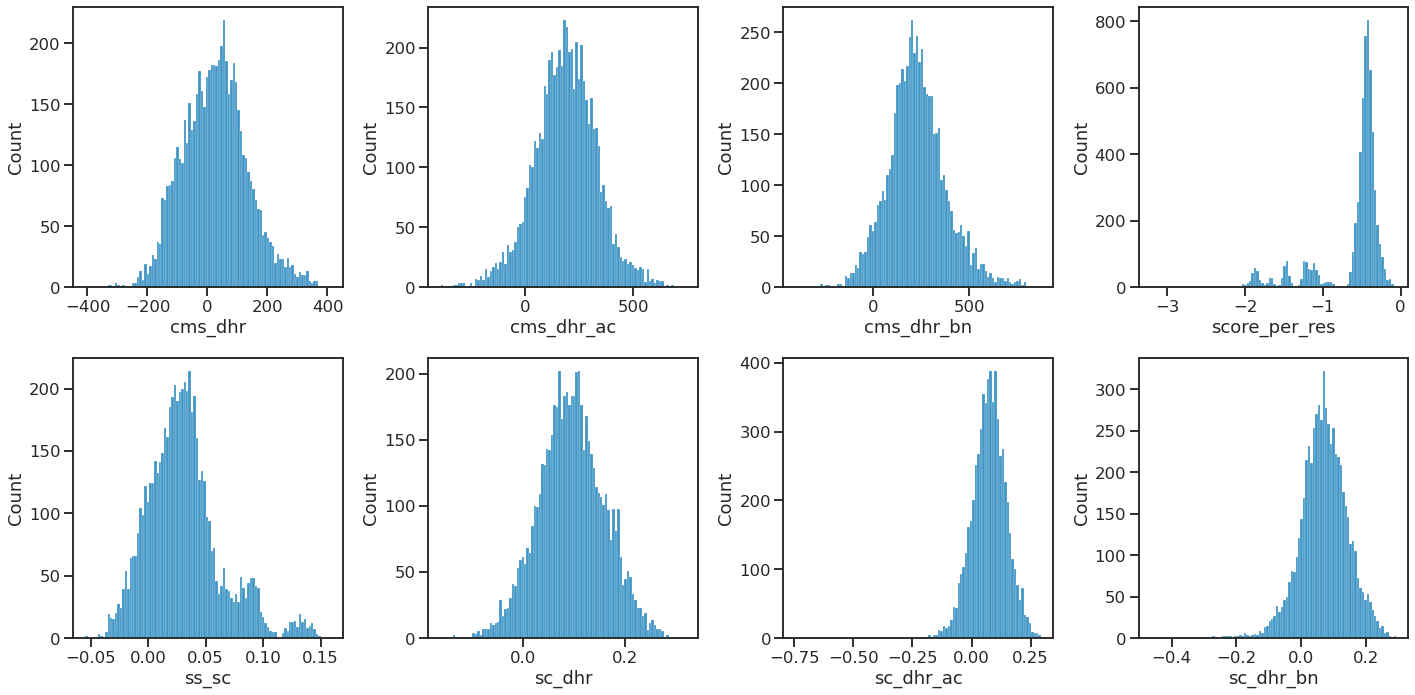

In [21]:
# Plots distributions of delta scores between the parent and the children.
# Delta scores are calculated by design_value - parent_value.
# For scores which I'm trying to maximize, higher delta values are better.
# Conclusion: all score_per_res are better than the parents, and sc and cms usually increase, even for the side domains!
# Only cms_dhr decreases significantly from the parent.
# So, let's just filter based on whether designs are as good as or better than the parent (cutoffs at 0).

delta_pairs = [('cms_dhr', 'cms_dhr'),
               ('cms_dhr_ac', 'cms_dhr'),
               ('cms_dhr_bn', 'cms_dhr'),
               ('score_per_res', 'score_per_res'),
               ('ss_sc', 'ss_sc'),
               ('sc_dhr', 'sc_dhr'),
               ('sc_dhr_ac', 'sc_dhr'),
               ('sc_dhr_bn', 'sc_dhr')]

score_terms, parent_terms = tuple(map(list, zip(*delta_pairs)))
# gets the columns to filter on from the parent df, then duplicate rows by parent such that rows correspond to the parents of the rows of filtered df
parent_aligned_df = parent_df[parent_terms].loc[filtered_df['parent'], :]
parent_aligned_df.index = filtered_df.index
parent_aligned_df.columns = score_terms # fixes an issue with duplicate column names, and makes sure the output columns are correctly named
delta_df = filtered_df[score_terms] - parent_aligned_df

fig, axs = plt.subplots(2, 4, figsize=(20,10))

for col, ax in tqdm(zip(score_terms, axs.flatten())):
    sns.histplot(
        data=delta_df,
        x=col,
        ax=ax,
#         kde=True
#         hue='parent'
        bins=100
    )

plt.tight_layout()

In [23]:
# how do I determine these cutoffs? Look at distributions of delta cutoffs between the parent and the children

# here, "cutoff" means "if the design scores worse than the parent by x"
delta_cutoffs = [('cms_dhr', 'cms_dhr', 0, 1),
                 ('cms_dhr_ac', 'cms_dhr', 0, 1),
                 ('cms_dhr_bn', 'cms_dhr', 0, 1),
                 ('score_per_res', 'score_per_res', 0.2, 0),
                 ('ss_sc', 'ss_sc', 0, 1),
                 ('sc_dhr', 'sc_dhr', 0, 1),
                 ('sc_dhr_ac', 'sc_dhr', 0, 1),
                 ('sc_dhr_bn', 'sc_dhr', 0, 1)]

delta_filtered_df = filter_df_delta(filtered_df, parent_df, delta_cutoffs)

2862


In [24]:
filtered_json_path = os.path.join(output_path, "filtered_designs.json")
delta_filtered_df.to_json(filtered_json_path)
filtered_list_path = os.path.join(output_path, "filtered_designs.list")
with open(filtered_list_path, 'w') as f:
    f.write('\n'.join(delta_filtered_df.index))

## Everything after this is for testing ##

In [20]:
from copy import deepcopy
test_df = deepcopy(filtered_df)

In [ ]:
# testing

sys.path.insert(0, "/home/broerman/projects/crispy_shifty")
from crispy_shifty.protocols.design import one_state_design_unlooped_dimer

pyrosetta.distributed.maybe_init(**{
    "options": "-corrections::beta_nov16 true",
    "extra_options":{
        "-out:level": "100",
        "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
        "-indexed_structure_store:fragment_store": "/home/bcov/sc/scaffold_comparison/data/ss_grouped_vall_all.h5",
        "-precompute_ig": "true"
}})

import pyrosetta.distributed.io as io
file = '/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/01_make_states/decoys/0000/CSD_01_make_states_4c315eabb34a449a886b9e9bd9b8227a.pdb.bz2'

for i in tqdm(range(1)):
    pposes = one_state_design_unlooped_dimer(None, **{'pdb_path': file})
    for ppose in pposes:
        designed_pose = io.to_pose(ppose)
        # designed_pose.dump_pdb(f"/home/broerman/projects/dimeric_hinges/dimeric_hinges_2/testing/02_design_filter/X23_3_20_3_ct7_fc.pdb")
        designed_pose.dump_pdb(f"/home/broerman/projects/dimeric_hinges/dimeric_hinges_2/testing/02_design_filter/X23_3_20_3_ct7_fc_fixbb2_{i:02d}.pdb")

  0%|          | 0/1 [00:00<?, ?it/s]

0.00 min: Generated interface selector
0.00 min: Generated interface design task factory
0.06 min: Generated score functions
0.06 min: Generated movemaps


/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


select design_sel, (chain A and resid 2,6,28,31,32,35,38,39,42,46,49,50,51,52,54,55,56,58,59,61,62,65,66,69,73,75,77,78,80,81,82,84,85,87,88,89,90,91,92,93,94,95) or (chain B and resid 103,106,107,109,110,113,114,117,122,123,125,126,127,129,130,132,133,134,136,137,140,182) or (chain C and resid 245,247,248,251,252,254,255,256,258,259,262,263,265,266,268,270,271,274,275,277,278,279,281,282,284,285) or (chain D and resid 289,290,291,292,293,294,295,296,297,299,300,301,303,304,306,307,308,310,315,318,319,322,323,325,326,327,329,330,332,333,334,342,346,349,350,353,356,360)
0.21 min: Generating structure profile...complete.
0.21 min: Starting 1 round of fixed backbone design...complete.
36.09 min: Starting 2 rounds of flexible backbone design...complete.
36.09 min: Clearing constraints...complete.
36.09 min: Scoring contact molecular surface and shape complementarity...core.scoring.sc.ShapeComplementarityCalculator: {0} [ ERROR ] Failed: No molecular dots generated!
protocols.simple_filters

In [ ]:
# testing

sys.path.insert(0, "/home/broerman/projects/crispy_shifty")
from crispy_shifty.protocols.design import one_state_design_unlooped_dimer

pyrosetta.distributed.maybe_init(**{
    "options": "-corrections::beta_nov16 true",
    "extra_options":{
        "-out:level": "100",
        "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
        "-indexed_structure_store:fragment_store": "/home/bcov/sc/scaffold_comparison/data/ss_grouped_vall_all.h5",
        "-precompute_ig": "true"
}})

import pyrosetta.distributed.io as io
file = '/home/broerman/projects/dimeric_hinges/dimeric_hinges_2/testing/01_make_states/DHR21/DHR21_A_-1_0_DHR21_B_1_1.pdb'

for i in tqdm(range(1)):
    pposes = one_state_design_unlooped_dimer(None, **{'pdb_path': file})
    for ppose in pposes:
        designed_pose = io.to_pose(ppose)
        # designed_pose.dump_pdb(f"/home/broerman/projects/dimeric_hinges/dimeric_hinges_2/testing/02_design_filter/X23_3_20_3_ct7_fc.pdb")
        designed_pose.dump_pdb(f"/home/broerman/projects/dimeric_hinges/dimeric_hinges_2/testing/02_design_filter/DHR21_{i:02d}.pdb")

  0%|          | 0/1 [00:00<?, ?it/s]

0.00 min: Generated interface selector
0.00 min: Generated interface design task factory
0.06 min: Generated score functions
0.06 min: Generated movemaps


/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


select design_sel, (chain A and resid 2,5,9,25,28,38,39,40,42,43,44,46,47,50,51,54,55,59,60,62,63,64,66,67,69,70,71,73) or (chain B and resid 74,76,77,78,80,81,82,84,85,87,88,96,100,103,104,107,108) or (chain C and resid 151,187,188,189,190,192,193,195,196,197,199,200,203,204,208,209,211,212,213,215,216,217,218,219,220,221,222) or (chain D and resid 224,226,227,229,230,231,233,234,235,236,237,238,240,245,246,247,249,250,252,253,254,256,257,259,268,269,272,275,276)
0.22 min: Generating structure profile...complete.
5.91 min: Starting 1 round of fixed backbone design...complete.
32.86 min: Starting 2 rounds of flexible backbone design...complete.
88.69 min: Clearing constraints...complete.
88.69 min: Scoring contact molecular surface and shape complementarity...core.scoring.sc.ShapeComplementarityCalculator: {0} [ ERROR ] Failed: No molecular dots generated!
protocols.simple_filters.ShapeComplementarityFilter: {0} [ ERROR ] Issue running shape complementarity calculator - returning -1 in